<a href="https://colab.research.google.com/github/crodier1/machine_learning_deep_learning/blob/main/Pslam_Generator_Source_Code_NLP_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the source code for Pslam_Generator_Seq2Seq_NLP. I highly recomend that you check that model out, so you don't have to retrain this model. That would take a long time. This code creates and trains the model using the Book of Pslams from the Bible. I uses seq2seq to randomly generate bibical pslams.

In [1]:
!pip install future

from __future__ import print_function, division
from builtins import range, input

In [2]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [3]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3_000
EMBEDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [5]:
!wget -nc https://raw.githubusercontent.com/crodier1/machine_learning_deep_learning/refs/heads/main/resources/pslams.txt

File ‘pslams.txt’ already there; not retrieving.



In [6]:
input_texts = []
target_texts = []
for line in open('pslams.txt'):

    line = re.sub(r'^\d+:\d+\s+', '', line).rstrip()

    if not line:
        continue
    input_line = '<sos> ' + line
    target_line = line + ' <eos>'

    input_texts.append(input_line)
    target_texts.append(target_line)

all_texts = input_texts + target_texts


In [7]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_texts)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [8]:
max_sequences_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length from data is {}'.format(max_sequences_length_from_data))

Max sequence length from data is 45


In [9]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 4940 unique tokens.


In [10]:
max_sequence_length = min(max_sequences_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (2461, 45)


In [11]:
if not os.path.exists("/content/glove6b"):
  !wget -nc https://nlp.stanford.edu/data/glove.6B.zip
  !unzip glove.6B.zip -d /content/glove6b

In [12]:
print('Loading word vectors...')
word2vec = {}

with open(os.path.join('/content/glove6b/glove.6B.%sd.txt' % EMBEDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [13]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [14]:
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        if word > 0:
            one_hot_targets[i, t, word] = 1

In [15]:
embedding_layer = Embedding(
    num_words,
    EMBEDING_DIM,
    weights=[embedding_matrix],
    # trainable=False
)

In [16]:
print('Building model...')

input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)

Building model...


In [17]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate= 0.01),
    metrics=['accuracy']
)

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Display messages when early stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

In [20]:
print('training model')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
    [input_sequences, z, z],
    one_hot_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping]
)

training model
Epoch 1/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 922ms/step - accuracy: 0.0186 - loss: 3.0079 - val_accuracy: 0.0222 - val_loss: 2.0784
Epoch 2/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 809ms/step - accuracy: 0.0266 - loss: 2.3692 - val_accuracy: 0.0202 - val_loss: 2.0779
Epoch 3/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 678ms/step - accuracy: 0.0289 - loss: 2.3648 - val_accuracy: 0.0202 - val_loss: 2.0742
Epoch 4/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 652ms/step - accuracy: 0.0272 - loss: 2.3674 - val_accuracy: 0.0202 - val_loss: 2.0638
Epoch 5/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.0271 - loss: 2.3339 - val_accuracy: 0.0202 - val_loss: 2.0550
Epoch 6/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 803ms/step - accuracy: 0.0269 - loss: 2.2923 - val_accuracy: 0.0202 - val_loss: 2.0499
Epoch 7/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 720ms/step - accuracy: 0.0273 - loss: 2.3094 - val_accuracy: 0.0206 - val_loss: 2.0442
Epoch 8/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 804ms/step - accuracy: 0

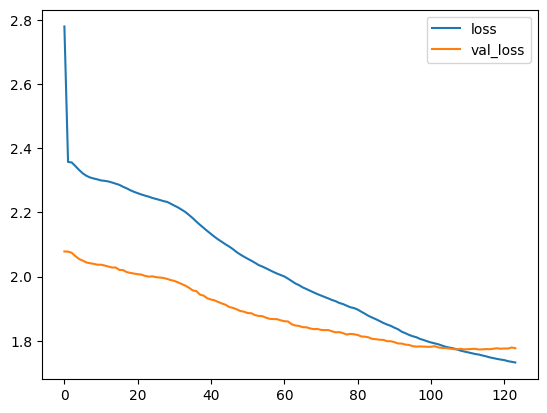

In [21]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

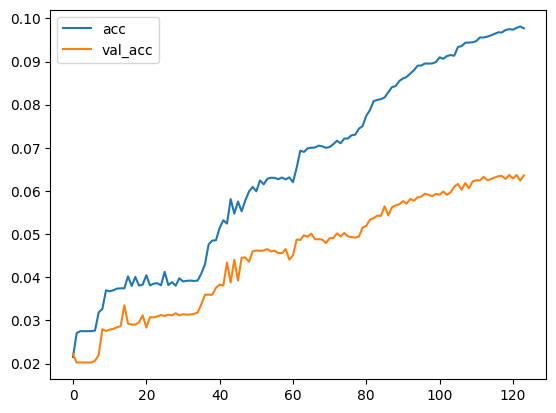

In [22]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [23]:
input2 = Input(shape=(1,))
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c])
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [24]:
idx2word = {v: k for k, v in word2idx.items()}

In [25]:
def sample_line():
  np_input = np.array([[word2idx['<sos>']]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  eos = word2idx['<eos>']

  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c], verbose=0)

    probs = o[0, 0]
    if np.argmax(probs) == 0:
      print('zero highest probability')

    probs[0] = 0

    probs /=  probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    np_input[0, 0] = idx

  return ' '.join(output_sentence)

In [26]:
while True:
  for _ in range(4):
    print(sample_line())

  ans = input('--Would you like to generate another pslam? y/n --')
  if ans and ans[0].lower().startswith('n'):
    break

timbrel one of my word of that days given me in feareth the trust: said have the lord, and their reproach, for thou hast satisfied, ever preserve under thee: vanity, of of girded away, that amen. put my lips.
the voice of me: thousands of of that reacheth of in covered deliver mine head; destruction hath shall shall void the belly and trust for call against the lord: then i for i man that those not known their trouble, and i fear them. see,
he be except wax understand, and not seek the gladness nor his hiding ears will that walk go from us ordained place fools, waste their covenant are my right name: mindful of we the call to god: at offerings and the holiness i hath forgotten
shall and we praises song; and my servant: oh that is spear, and such chasten me people my light will ye helped thy holy himself, would at not innocent: of long? and and of against them be appear the bones places. yet seek my heart
--Would you like to generate another pslam? y/n --y
who shall appear upon the sea,

In [27]:
model.save('pslams_model.h5')


In [30]:
sampling_model.save('pslams_sampling_model.h5')

In [32]:
import pickle
with open('idx2word.pkl', 'wb') as f:
    pickle.dump(idx2word, f)

In [33]:
import pickle
with open('word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)